In [6]:
import numpy as np
import pandas as pd
from pylab import rcParams
%pylab inline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from operator import itemgetter
from scipy.stats import itemfreq
import scipy.spatial as sp


Populating the interactive namespace from numpy and matplotlib


In [9]:
rcParams['figure.figsize'] = 8,8

### Heatmap dati normalizzati e smooth (per confronto con dati clusterizzati)

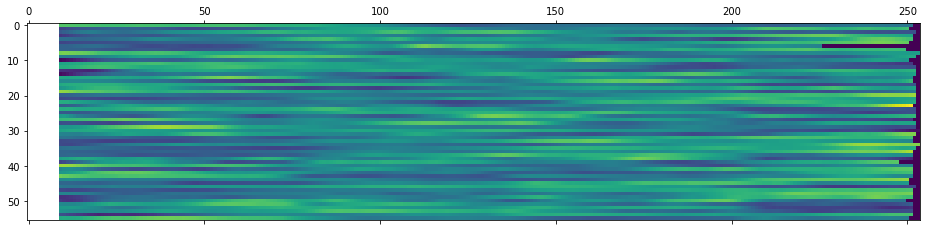

In [10]:
series = pd.Series.from_csv('dataset/ibm_daily_1962-2018.csv', sep='\t',header=0)
series = series["1962-01-02":"2017-12-29"]

groups = series.groupby(pd.Grouper(freq='A'))
years = []
yearly_series = []
yearly_list = []
for name, group in groups:
    years.append(name.year) # Lista contenente gli anni
    yearly_series.append(pd.Series(group)) # Lista contenente serie pandas per ogni anno
    yearly_list.append(list(group.values)) # Lista contenente liste per ogni anno

groups = series.groupby(pd.Grouper(freq='A'))
mm = pd.DataFrame()
for name, group in groups:
    norm_values = (group.values - mean(group.values)) / std(group.values)
    norm_series = pd.Series(norm_values) #trasformo in serie per calcolare la rolling mean
    shift_series = norm_series.rolling(window=10).mean()
    norm_array = np.array(shift_series)
    # Padding performed to have series of same length -- important only for plotting the matrix
    pad_values = np.pad(norm_array,(0,254-len(norm_array)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
matshow(mm.T, interpolation=None, aspect='auto')

In [12]:
# Serie Normalizzate + Smoothing
groups = series.groupby(pd.Grouper(freq='A'))
yearly_list_smooth = []
for name, group in groups:
    group_values = list(group.values)
    scaling_values = (group_values - mean(group_values))/std(group_values)
    scaling_series = pd.Series(scaling_values) #trasformo in serie per calcolare la rolling mean
    shift_series = scaling_series.rolling(window=10).mean()
    yearly_list_smooth.append(list(shift_series))

#rimozione missing values generati dallo smoothing con media mobile
yearly_series_smooth = []
for i in range(len(yearly_list_smooth)):
    yearly_series_smooth.append(pd.Series(yearly_list_smooth[i]))
    yearly_series_smooth[i] = pd.Series.dropna(yearly_series_smooth[i])

## Clustering con Structural Distances

In [15]:
# Importo le matrici come dataframe

norm_feat_df = pd.read_csv("distance_matrices/norm_feat.csv", header = None)

In [16]:
# Converto le i dataframe in liste di liste
norm_feat = norm_feat_df.values.tolist()

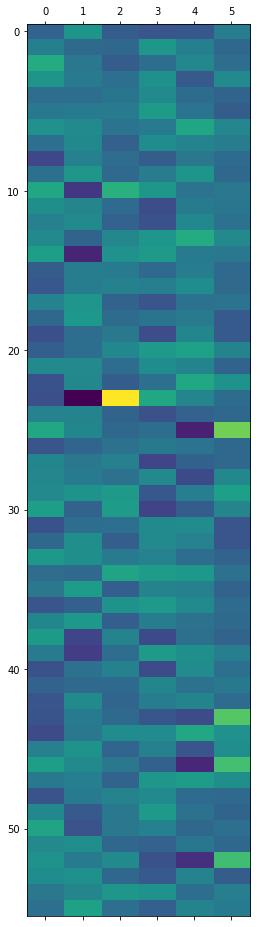

In [17]:
matshow(norm_feat, interpolation=None, aspect='auto')

### KMeans

Per la scelta del parametro k, che indica il numero di cluster, si è osservata la distribuzione di SSE per valori tra 2 e 20.

#### Scelta di k

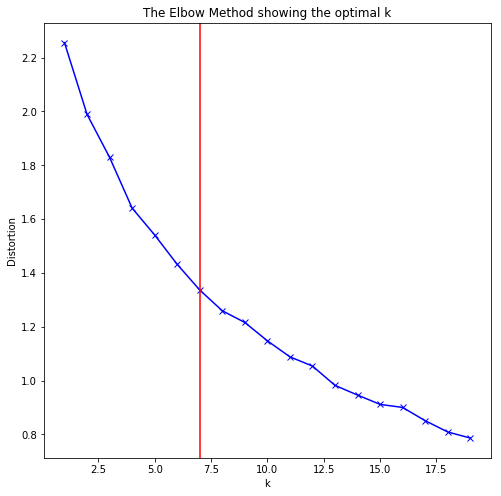

In [18]:
from scipy.spatial.distance import cdist
# k means determine k
distortions = []
norm_feat = np.array(norm_feat)
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(norm_feat)
    kmeanModel.fit(norm_feat)
    distortions.append(sum(np.min(cdist(norm_feat, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / norm_feat.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.axvline(color = 'red',x = 7)
plt.show()

#### Clustering

In [19]:
db = KMeans(n_clusters=7, random_state=0).fit(norm_feat)

n_clusters_ = len(set(db.labels_))

print('Number of clusters found: %d' % n_clusters_)
print (itemfreq(db.labels_))

year_index= pd.Index(years) # Converto la lista degli anni in un pandas index array!!!
cluster_sets = [ (l_,year_index[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print (pp[0], "\t--> ", list(pp[1]))

Number of clusters found: 7
[[ 0 19]
 [ 1  4]
 [ 2  6]
 [ 3 16]
 [ 4  1]
 [ 5  3]
 [ 6  7]]
0 	-->  [1966, 1967, 1969, 1970, 1971, 1977, 1978, 1980, 1981, 1983, 1984, 1988, 1993, 1994, 1997, 2002, 2003, 2004, 2010]
1 	-->  [1987, 2005, 2008, 2014]
2 	-->  [1963, 1972, 1976, 2001, 2011, 2012]
3 	-->  [1962, 1964, 1968, 1973, 1974, 1979, 1986, 1989, 1991, 1992, 1995, 1999, 2000, 2013, 2015, 2017]
4 	-->  [1985]
5 	-->  [1965, 1990, 2007]
6 	-->  [1975, 1982, 1996, 1998, 2006, 2009, 2016]


/Users/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


#### Plot cluster 2

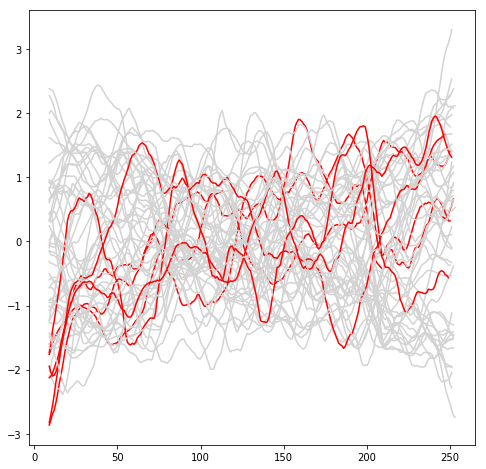

In [20]:
for i in range(len(db.labels_)):
    plot(yearly_series_smooth[i],'r-' if db.labels_[i]==2 else 'lightgray')

#### Confronto Heatmap pre/post clustering

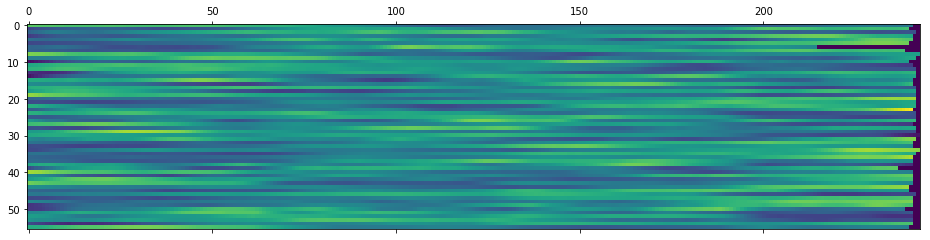

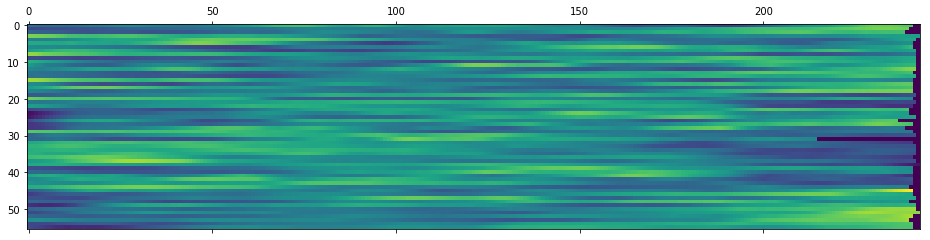

In [22]:
groups = series.groupby(pd.Grouper(freq='A'))
mm = DataFrame()
for name, group in groups:
    scaling_values = (group.values - mean(group.values))/std(group.values)
    scaling_series = pd.Series(scaling_values)
    shift_values = scaling_series.rolling(window=12).mean()
    shift_values=shift_values.dropna()
    shift_values = np.array(shift_values)
    pad_values = np.pad(shift_values,(0,254-len(group.values)),'constant',constant_values=-3)
    mm["%s" % (name.year)] = pad_values
    
mm_sort=sorted(zip(array(mm.T),db.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm.T, interpolation=None, aspect='auto')
matshow(mm_sort2, interpolation=None, aspect='auto')